# Outliers, Anomalies 
Refs:<br>
<a href="https://www.kaggle.com/code/rafjaa/dealing-with-very-small-datasets/notebook">1. Dealing with very small datasets</a><br>
<a href="https://www.linkedin.com/pulse/how-use-machine-learning-anomaly-detection-condition-flovik-phd/">2. How to use machine learning for anomaly detection and condition monitoring</a>

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
#the following gives access to utils folder
#where utils package stores shared code
import os
import sys

## Outliers and Anomalies, what are they?

from <a href="https://stats.stackexchange.com/questions/189664/difference-between-anomaly-and-outlier#:~:text=An%20anomaly%20is%20a%20result,base%20distribution%20(an%20improbability).&text=Quoting%20source%20for%20the%20definitions%20and%20example%20would%20highly%20improve%20the%20answer.">Difference between Anomaly and Outlier</a>. The terms are largely used in an interchangeable way. "Outlier" refers to something lying outside the norm - so it is usually used for rare observations. In statistics, on a normal distribution, you would consider three sigma (standard deviations) to be outliers. That is 99.7% of your objects are expected to be "normal". 

Anomalous data can be connected to problems or rare events such as bank fraud, medical problems, structural defects, malfunctioning equipment etc. This connection makes anomalies interesting from a data science perspective.

Sometimes these anomalous data points are erroneous and should be removed. For instance, a bad sensor generating bogus data<br>
Sometimes these anomalous data points indicate a change in system parameters and are of interest.  For instance a set of wheel bearing sensors that read consistant ranged values until the bearings start to fail.<br>

### How do they affect model training?

In either case, anomalous data points change the distribution of data, which in turn changes the model that is fit to that data.  This is desired if the anomalous point represents a rare event like bank fraud.  It is probably unwanted if it represents a reading from a broken sensor.

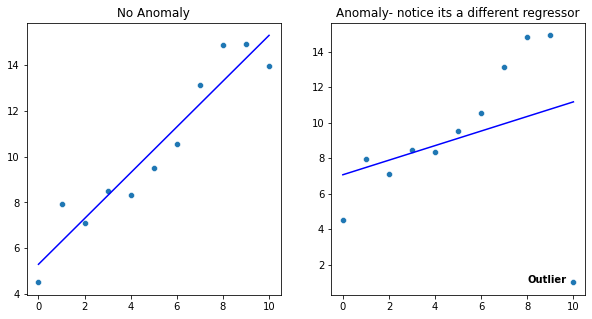

In [82]:
#show linear regression on a small dataset with and without an outlier
import utils as ut
X,y = ut.gendata(11,max_val= 1, min_val=0, max_rise=5)
# X,y = ut.gendata(11)

from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X=X, y=y);

#lets add an outlier
yo=y.copy()
yo[10]=1    #an anomalous point
reg1 = linear_model.LinearRegression()
reg1.fit(X=X, y=yo);

#plot points and linear regression line
fig,axs=plt.subplots(1,2,figsize=(10,5))

#plot first set
ax=sns.scatterplot(x=X.squeeze(), y=y.squeeze(),ax=axs[0])
ax=sns.lineplot(x=X.squeeze(), y=reg.predict(X).squeeze(),color='blue',ax=axs[0] )
ax.set_title("No Anomaly")

#plot second set
ax=sns.scatterplot(x=X.squeeze(), y=yo.squeeze(),ax=axs[1])
# add text annotation
plt.text(8, 1, "Outlier", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax=sns.lineplot(x=X.squeeze(), y=reg1.predict(X).squeeze(),color='blue',ax=axs[1] )
_=ax.set_title("Anomaly- notice its a different regressor")

## Finding them
You can spot them visually if you plot a 2 dimensional dataset.  For instance in the image below from ref 2, the anomaly stands out in the left plot (but not in the 2 plots to the right).<br>
![](./img1.png)

For more dimensions you need a better algorithm.

## Anomaly algorithm 1: Anything outside of 3 standard deviations
![](./img3.png)<br>
Pure statistics, any value that falls outside of 3 standard deviations (or 2 or 3 or whatever you like) is considered an anomaly.

In [157]:
# multiply and add by random numbers to get some real values
rng = np.random.RandomState(42)

THREE_STD_DEV=3

# Generate train data
X_train = 0.3 * rng.randn(100)

#lets find the std deviation and mean of train data
std_trn = np.std(X_train)
mean_trn=X_train.mean()

#and the high and low ranges to be considered an inlier
low=mean_trn-THREE_STD_DEV*std_trn
high=mean_trn+THREE_STD_DEV*std_trn

print(f'The mean of train data={mean_trn:.3f}')
print(f'The std of train data={std_trn:.3f}')
print(f'{low:.2f} <= Data <={high:.2f} to be an inlier')

# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20))

#an see if its withen THREE_STD_DEV of the mean of the training data
preds=[-1 if (val>high or val < low) else 1 for val in X_outliers ]
for p,v in zip(preds,X_outliers):
    print(f'Val {v:.2f} pred={p}')

The mean of train data=-0.031
The std of train data=0.271
-0.84 <= Data <=0.78 to be an inlier
Val -0.66 pred=1
Val -2.22 pred=-1
Val -3.04 pred=-1
Val -1.30 pred=-1
Val 3.54 pred=-1
Val -1.41 pred=-1
Val 0.15 pred=1
Val 1.62 pred=-1
Val -1.09 pred=-1
Val 3.77 pred=-1
Val 3.70 pred=-1
Val -1.99 pred=-1
Val -0.02 pred=1
Val -1.59 pred=-1
Val -1.72 pred=-1
Val -3.70 pred=-1
Val 0.88 pred=-1
Val 0.02 pred=1
Val -3.59 pred=-1
Val -1.77 pred=-1


## Anomaly algorithm 2: Using Isolation Forest (a tree based method)
The first thing to note is that this is an unsupervised algorithm. It has to discover anomalies.

Algorithm:
1. a random sub-sample of the data is selected and assigned to a binary tree.
2. Branching of the tree starts by selecting a random feature (from the set of all N features). And then a random threshold to split on  ( any value in the range of minimum and maximum values of the selected feature).
3. If the value of a data point is less than the selected threshold, it goes to the left branch else to the right. And thus a node is split into left and right branches.
4. This process from step 2 is continued recursively till each data point is completely isolated or till max depth(if defined) is reached.

The above steps are repeated to construct random binary trees.

The path length, averaged over many trees, from the root node to the terminating node can serve as a proxy for anomalous points. That is,  short path lengths means it is easy to split a point from the pack.  So that point is likely anomalous.
See <a href="https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py">IsolationForest example</a> for original code

Hyperparameters<br>
contamination: the amount of outliers you expect to find
               

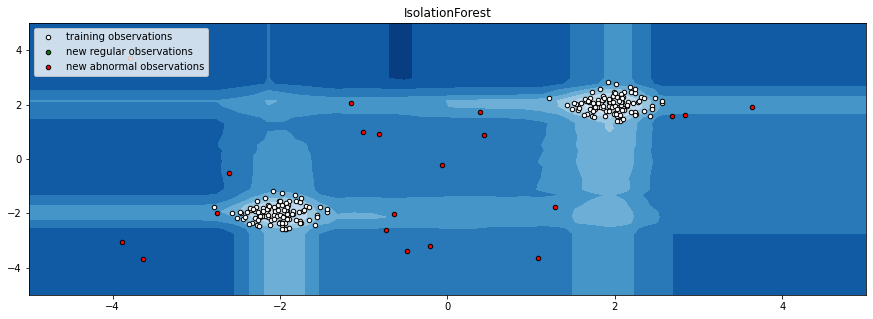

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng, contamination=0.00001)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,axs=plt.subplots(figsize=(15,5))
axs.set_title("IsolationForest")
axs.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = axs.scatter(X_train[:, 0], X_train[:, 1], c="white", s=20, edgecolor="k")
# b2 = axs.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor="k")
c = axs.scatter(X_outliers[:, 0], X_outliers[:, 1], c="red", s=20, edgecolor="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
axs.legend(
    [b1, b2, c],
    ["training observations", "new regular observations", "new abnormal observations"],
    loc="upper left",
)
plt.show()

In [120]:
#1 means its an inlier, -1 means its an outlier
y_pred_test

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1])

In [121]:
y_pred_outliers

array([-1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

## What about using anomalous data as an indicator that something is wrong or going wrong?

A classic case is machine bearing condition monitoring.  Bearings run well for a time, but will eventually start to degrade.  When this happens sensor data starts to change which serves as an early warning to service or replace the bearings before they fail.  See ref 1 for a treatment of this topic.